<a href="https://colab.research.google.com/github/souldrive7/ECP/blob/main/%E6%95%99%E5%B8%AB%E3%81%82%E3%82%8A%E5%AD%A6%E7%BF%92%E2%80%97%E8%AA%B2%E9%A1%8C%E2%80%97%E9%A3%AF%E5%B1%B1%E5%85%88%E7%94%9F%E2%80%97xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教師あり学習 課題（飯山先生）

### 氏名：後藤 晃郁

### 学籍番号：6025131

### 提出日：2025/5/15

# 課題：Xgboost.ipynbを編集して以下の実験を行い，結果と考察を提出してください

---

1.データに対して，予測に寄与しない乱数（例えば，ガウス分布に従うノイズ）を加え，変数の重要度がどのように変化するか確認してください．

2.データに対して，“Glucose”と非常によく似た特徴（例えば，Glucoseに分散5程度のガウス分布に従うノイズを加えた変数）を加え，変数の重要度がどのように変化するか確認してください．

3.さらに，“Glucose”と非常によく似た特徴を（10個程度）増やした場合に変数の重要度がどのように変化するか確認してください．

4．（発展）一つの変数を連続値ではなくカテゴリ値に変更した場合に変数の重要度がどのように変化するか確認してください．
* 不純度ベースの重要度計算だと，high cardinality（カテゴリ数や連続値の取り得るパターンが多い）変数が有利になりがち.データによっては逆のパターンもありえます

〆切：5/25 23:59(JST)
提出方法：PDFファイルをSULMSに提出
※ 重要度のグラフと，簡単な考察(2,3行)を書いてください．

---

## 1.データに対して，予測に寄与しない乱数（例えば，ガウス分布に従うノイズ）を加え，変数の重要度がどのように変化するか確認してください．

#### ■インポート■

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from xgboost import XGBClassifier
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

import warnings

# XGBoost core の UserWarning（use_label_encoder 未使用）を無視
warnings.filterwarnings(
    "ignore",
    message=r".*Parameters: { \"use_label_encoder\" } are not used.*",
    category=UserWarning,
    module="xgboost.core"
)

In [2]:
# インストール用
!pip install japanize-matplotlib

In [3]:
import japanize_matplotlib

#### ■データ概要■

In [4]:
# 1. データセットの取得
dataset = fetch_openml("pima-indians-diabetes", version=1, as_frame=True)  # Pimaデータセットを取得
# こんな感じのデータです．8変数の説明変数．Outcomeは0 or 1
dataset.frame.head()  # データフレームの最初の5行を表示

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0


In [5]:
# 1.1 参考までに相関行列を表示
corr = dataset.frame.corr()
# 相関行列をヒートマップで表示．有効数字2桁
corr.style.format(precision=2).background_gradient(cmap="coolwarm")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54,0.22
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26,0.47
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24,0.07
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11,0.07
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04,0.13
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04,0.29
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03,0.17
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00,0.24
Outcome,0.22,0.47,0.07,0.07,0.13,0.29,0.17,0.24,1.00


In [6]:
df = dataset.frame
# dfコピー
df_add_rn = df.copy()

---
#### 問題の解釈の仕方により、解が異なると考え2つの予測を行った
-予測1.1既存の全説明変数（outcome以外の既存の全変数）

-予測1.2ランダム列を追加し提供度合いはどうか

#### ■予測1.1■

 -予測1.1 既存の全説明変数（outcome以外の既存の全変数）

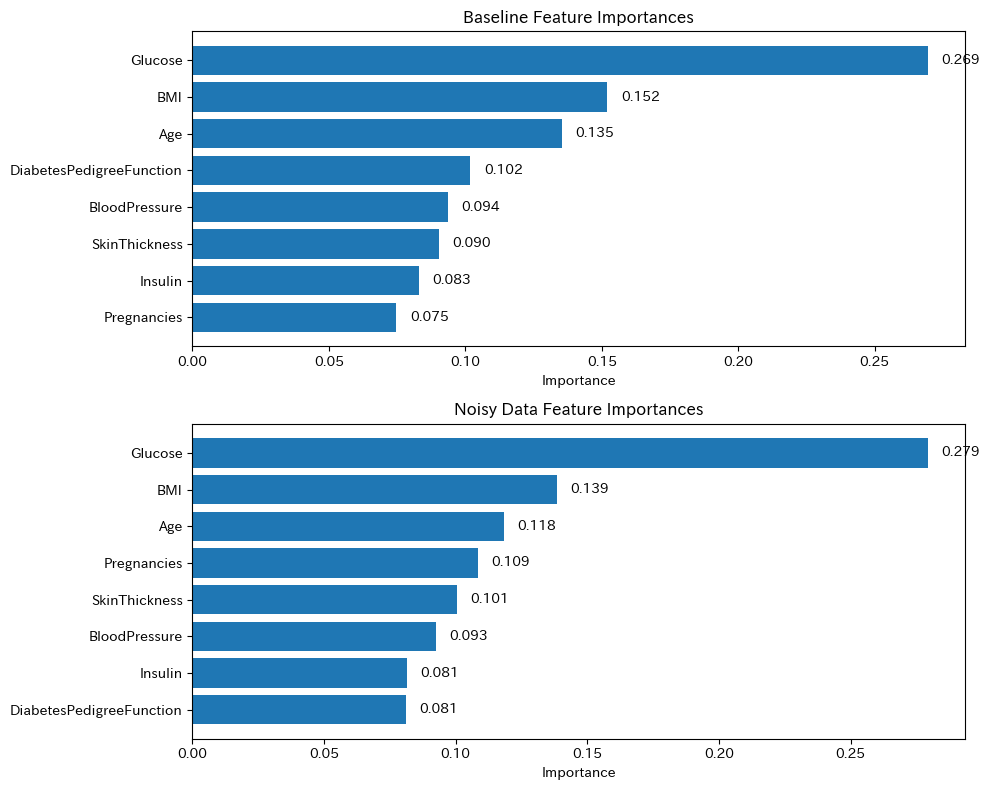

Feature Importance Matrix:
                          Baseline     Noisy
Pregnancies               0.074684  0.108506
Glucose                   0.269498  0.279343
BloodPressure             0.093568  0.092506
SkinThickness             0.090205  0.100501
Insulin                   0.082889  0.081355
BMI                       0.151984  0.138518
DiabetesPedigreeFunction  0.101782  0.081027
Age                       0.135391  0.118244


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# --- 1. ベースラインモデルの学習 ---
X = df.drop(columns='Outcome')
y = df['Outcome']

model_base = xgb.XGBClassifier(eval_metric='logloss', random_state=0)
model_base.fit(X, y)
imp_base = dict(zip(X.columns, model_base.feature_importances_))

# --- 2. 全説明変数にノイズを加えたデータの作成＆モデル学習 ---
df_noise = df.copy()
np.random.seed(0)
for col in X.columns:
    df_noise[col] += np.random.normal(loc=0, scale=np.sqrt(5), size=df_noise.shape[0])

X_noise = df_noise.drop(columns='Outcome')
model_noise = xgb.XGBClassifier(eval_metric='logloss', random_state=0)
model_noise.fit(X_noise, y)
imp_noise = dict(zip(X_noise.columns, model_noise.feature_importances_))

# --- 3. 重要度マトリクスの作成 ---
df_imp4 = pd.DataFrame({
    'Baseline': [imp_base[f] for f in X.columns],
    'Noisy':    [imp_noise[f] for f in X.columns],
}, index=X.columns)

# --- 4. ２つのグラフを縦に並べて可視化（数値ラベル付き） ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

for ax, (series, title) in zip(axes, [
    (df_imp4['Baseline'], 'Baseline Feature Importances'),
    (df_imp4['Noisy'],    'Noisy Data Feature Importances')
]):
    s_sorted = series.sort_values(ascending=False)
    ax.barh(s_sorted.index, s_sorted.values)
    for i, v in enumerate(s_sorted.values):
        ax.text(v + 0.005, i, f"{v:.3f}", va='center')
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

# --- 5. 重要度マトリクスを出力 ---
print("Feature Importance Matrix:")
print(df_imp4)


#### ■予測1*.2*■

 -予測1.2ランダム列を追加し提供度合いはどうか

In [8]:
# ランダムノイズ列を追加
df_add_rn["noise"] = np.random.randn(len(df_add_rn))

In [9]:
# Outcomeをドロップ
df = dataset.frame
X = df.drop(columns=["Outcome"])  # Outcome列を除外
y = df["Outcome"].astype(int)  # Outcome列を抽出 & 整数型に変換

# Outcomeをドロップ_ノイズ列追加
df_add_rn = dataset.frame
X1 = df_add_rn.drop(columns=["Outcome"])  # Outcome列を除外
y1 = df_add_rn["Outcome"].astype(int)  # Outcome列を抽出 & 整数型に変換

In [10]:
# 3. 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500)  # 80%訓練，20%テスト

# 3. 訓練データとテストデータに分割_ノイズ列追加
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=500)  # 80%訓練，20%テスト

In [11]:
# 4. xgboostを使って学習
model = XGBClassifier(
    n_estimators=100,  # 木の数
    max_depth=3,  # 木の深さ
    learning_rate=0.1,  # 学習率
    random_state=100,  # 再現性のための乱数シード
)
model.fit(X_train, y_train)  # 訓練データで学習

# 4. xgboostを使って学習_ノイズ列追加
model.fit(X_train1, y_train1)  # 訓練データで学習

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=100, ...)

In [12]:
# 5. テストデータで予測
y_pred = model.predict(X_test)  # 予測
accuracy = accuracy_score(y_test, y_pred)  # 精度計算
print(f"Accuracy: {accuracy:.3f}")  # 精度を表示(小数点以下3桁)

# 5. テストデータで予測_ノイズ列追加
y_pred1 = model.predict(X_test1)  # 予測
accuracy1 = accuracy_score(y_test1, y_pred1)  # 精度計算
print(f"Accuracy1: {accuracy:.3f}")  # 精度を表示(小数点以下3桁)

Accuracy: 0.786
Accuracy1: 0.786


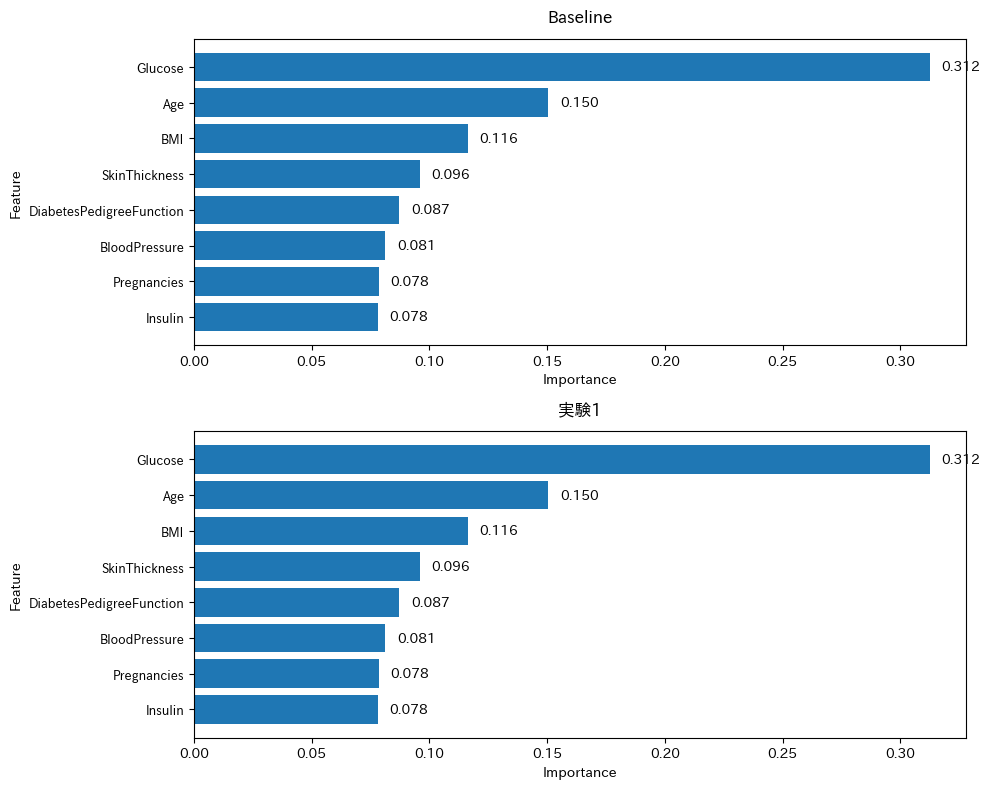

Feature Importance Matrix:
                          Baseline       実験1
feature                                     
Glucose                   0.312424  0.312424
Age                       0.150440  0.150440
BMI                       0.116174  0.116174
SkinThickness             0.095912  0.095912
DiabetesPedigreeFunction  0.087239  0.087239
BloodPressure             0.081299  0.081299
Pregnancies               0.078484  0.078484
Insulin                   0.078028  0.078028


In [13]:
# --- プロット用の準備 ---
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# 重要度を格納する辞書
importance_matrix = {}

# モデル／データの一覧
models = [model, model]   # Baselineモデルとノイズ追加モデル
datasets = [X, X1]         # 元データ と ノイズ追加データ
titles = ["Baseline", "実験1"]

# --- 各サブプロットの作成 ---
for ax, mdl, Xdf, title in zip(axes, models, datasets, titles):
    # 1) 重要度取得 & DataFrame化
    importances = mdl.feature_importances_
    feat_names  = Xdf.columns[:len(importances)]
    imp_df = pd.DataFrame({
        "feature":    feat_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # 2) 棒グラフ描画
    ax.barh(imp_df["feature"], imp_df["importance"])
    ax.invert_yaxis()
    ax.set_title(title, pad=12)
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    ax.tick_params(axis="y", labelsize=9)

    # 3) 数値ラベルの追加
    for i, (feat, imp) in enumerate(zip(imp_df["feature"], imp_df["importance"])):
        ax.text(imp + 0.005, i, f"{imp:.3f}", va='center')

    # 4) マトリクス用に格納
    importance_matrix[title] = imp_df.set_index("feature")["importance"]

plt.tight_layout()
plt.show()

# --- 重要度マトリクスの出力 ---
imp_matrix_df = pd.DataFrame(importance_matrix)
print("Feature Importance Matrix:")
print(imp_matrix_df)


#### ■考察1■

〇予測1.1既存の全説明変数（outcome以外の既存の全変数）

ノイズを加えると「Glucose≫BMI≫Age≫DiabetesPedigreeFunction≫…≫Pregnancies」の序列が崩れ、全体の重要度の平坦化した。

元々低かったPregnancies（0.075→0.109）やSkinThickness（0.090→0.101）が大きく上昇。中位のBMI（0.152→0.139）やAge（0.135→0.118）は重要度が低下した。

XGBoostは「ジニ不純度を最も下げる特徴」を選ぶため、信号対ノイズ比が下がると弱い変数にノイズ由来の分割が増え、importanceが歪む。


〇予測1.2ランダム列を追加し提供度合い

予測に無関係なノイズを追加しても、XGBoostの重要度評価は、混同行列も特徴量重要　度も変わらなかった。頑健である。

---

## 2.データに対して，“Glucose”と非常によく似た特徴（例えば，Glucoseに分散5程度のガウス分布に従うノイズを加えた変数）を加え，変数の重要度がどのように変化するか確認してください．

## ■似た変数を加えた重要度比較■

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


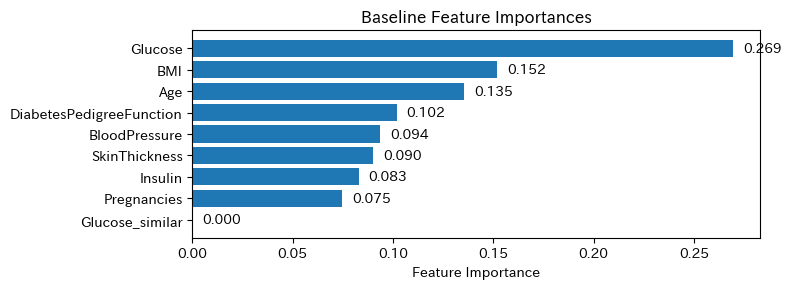

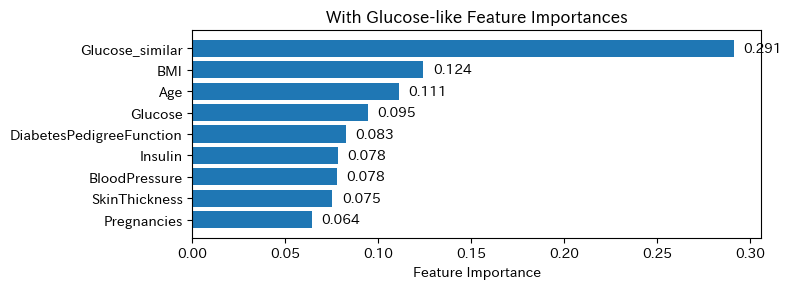

Feature Importance Matrix:
                          Baseline  With_Similar
Pregnancies               0.074684      0.064308
Glucose                   0.269498      0.094694
BloodPressure             0.093568      0.077838
SkinThickness             0.090205      0.075353
Insulin                   0.082889      0.078316
BMI                       0.151984      0.124344
DiabetesPedigreeFunction  0.101782      0.082827
Age                       0.135391      0.110993
Glucose_similar           0.000000      0.291328


In [15]:
# --- ① ベースラインモデルの学習 ---
X_base = df.drop(columns='Outcome')
y_base = df['Outcome']
model_base = xgb.XGBClassifier(use_label_encoder=False,
                               eval_metric='logloss',
                               random_state=0)
model_base.fit(X_base, y_base)
importances_base = dict(zip(X_base.columns, model_base.feature_importances_))

# --- ② Glucose に似た特徴を加えたモデルの学習 ---
df2 = df.copy()
np.random.seed(0)
df2['Glucose_similar'] = df2['Glucose'] + np.random.normal(
    loc=0, scale=np.sqrt(5), size=df2.shape[0]
)
X2 = df2.drop(columns='Outcome')
y2 = df2['Outcome']
model2 = xgb.XGBClassifier(use_label_encoder=False,
                           eval_metric='logloss',
                           random_state=0)
model2.fit(X2, y2)
importances2 = dict(zip(X2.columns, model2.feature_importances_))

# --- ③ 重要度マトリクスを作成 ---
features = list(X2.columns)
df_imp = pd.DataFrame({
    'Baseline':    [importances_base.get(f, 0) for f in features],
    'With_Similar':[importances2[f]         for f in features]
}, index=features)

# --- ④ ベースラインの棒グラフ（重要度順・数値ラベル付き） ---
df_base_sorted = df_imp.sort_values('Baseline', ascending=False)
plt.figure(figsize=(8, 3))
plt.barh(df_base_sorted.index, df_base_sorted['Baseline'])
for i, val in enumerate(df_base_sorted['Baseline']):
    plt.text(val + 0.005, i, f"{val:.3f}", va='center')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Baseline Feature Importances')
plt.tight_layout()
plt.show()

# --- ⑤ With Similar の棒グラフ（重要度順・数値ラベル付き） ---
df_sim_sorted = df_imp.sort_values('With_Similar', ascending=False)
plt.figure(figsize=(8, 3))
plt.barh(df_sim_sorted.index, df_sim_sorted['With_Similar'])
for i, val in enumerate(df_sim_sorted['With_Similar']):
    plt.text(val + 0.005, i, f"{val:.3f}", va='center')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('With Glucose-like Feature Importances')
plt.tight_layout()
plt.show()

# --- ⑥ 重要度マトリクスを出力 ---
print("Feature Importance Matrix:")
print(df_imp)


#### ■考察２■

〇Baseline（元データ）について

最も重要なのは「Glucose」で約0.269。
２位以下は順にBMI（≈0.151）、Age（≈0.135）、DiabetesPedigreeFunction（≈0.101）…と続き、追加した「Glucose_similar」は当然 0.000

〇With Glucose-like Feature Importances（Glucoseにノイズを加えた特徴を追加）

新しく加えた「Glucose_similar」が最も高い重要度（≈0.291）を獲得。
その結果、元の「Glucose」は約0.095にまで大きく低下。
他の変数も全体的に少しずつ重要度が下がっている。

〇考察
相関の高い特徴を追加すると、モデルはどちらを分割に使うかで重要度を奪い合い、一方が大きく上がってもう一方が下がるため、重要度の評価が歪みやすくなる。

---

## 3.さらに，“Glucose”と非常によく似た特徴を（10個程度）増やした場合に変数の重要度がどのように変化するか確認してください．


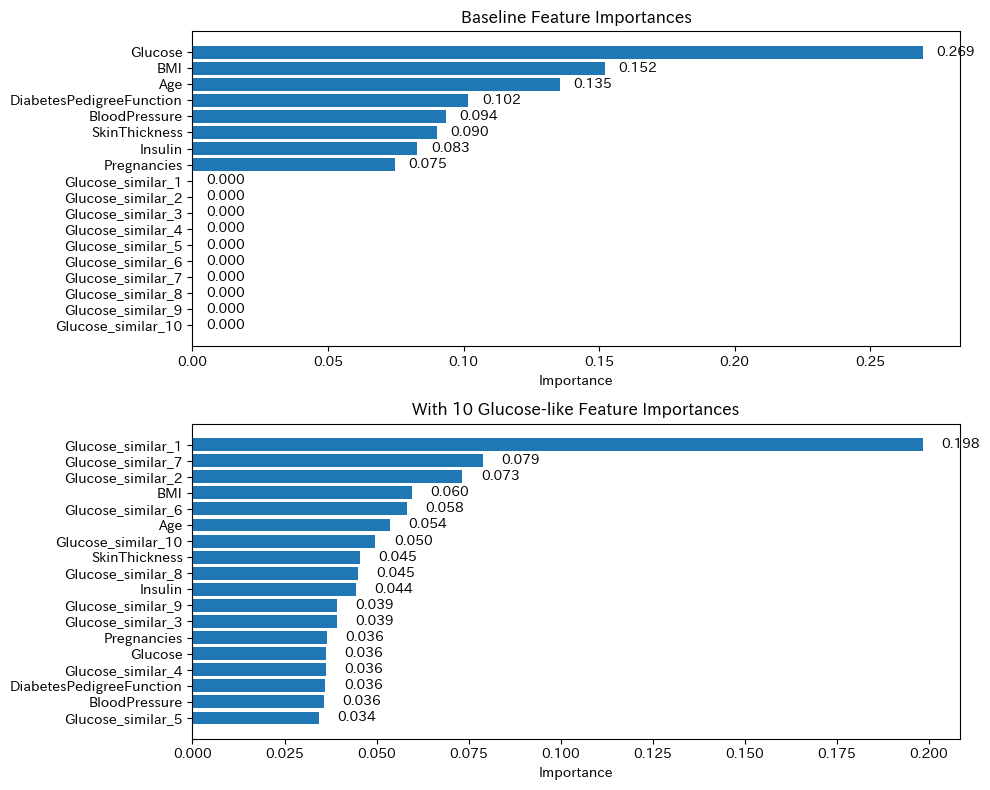

Feature Importance Matrix:
                          Baseline  With_10_Similar
Pregnancies               0.074684         0.036446
Glucose                   0.269498         0.036298
BloodPressure             0.093568         0.035623
SkinThickness             0.090205         0.045442
Insulin                   0.082889         0.044480
BMI                       0.151984         0.059678
DiabetesPedigreeFunction  0.101782         0.036081
Age                       0.135391         0.053589
Glucose_similar_1         0.000000         0.198391
Glucose_similar_2         0.000000         0.073314
Glucose_similar_3         0.000000         0.039189
Glucose_similar_4         0.000000         0.036276
Glucose_similar_5         0.000000         0.034269
Glucose_similar_6         0.000000         0.058139
Glucose_similar_7         0.000000         0.078968
Glucose_similar_8         0.000000         0.044902
Glucose_similar_9         0.000000         0.039260
Glucose_similar_10        0.000000   

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# --- ① ベースラインモデルの学習 ---
X_base = df.drop(columns='Outcome')
y_base = df['Outcome']
model_base = xgb.XGBClassifier(eval_metric='logloss', random_state=0)
model_base.fit(X_base, y_base)
imp_base = dict(zip(X_base.columns, model_base.feature_importances_))

# --- ② “Glucose” と非常によく似た特徴を10個追加したモデルの学習 ---
df10 = df.copy()
np.random.seed(0)
for i in range(1, 11):
    df10[f'Glucose_similar_{i}'] = (
        df10['Glucose'] + np.random.normal(0, np.sqrt(5), size=df10.shape[0])
    )
X10 = df10.drop(columns='Outcome')
y10 = df10['Outcome']
model10 = xgb.XGBClassifier(eval_metric='logloss', random_state=0)
model10.fit(X10, y10)
imp10 = dict(zip(X10.columns, model10.feature_importances_))

# --- ③ 重要度マトリクスの作成 ---
features = X10.columns
df_imp = pd.DataFrame({
    'Baseline':        [imp_base.get(f, 0)   for f in features],
    'With_10_Similar': [imp10.get(f, 0)      for f in features]
}, index=features)

# --- ④ 棒グラフで可視化（Baseline と With_10_Similar、数値ラベル付き） ---
# 並び替え
df_base_sorted = df_imp.sort_values('Baseline', ascending=False)
df10_sorted     = df_imp.sort_values('With_10_Similar', ascending=False)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Baseline
axes[0].barh(df_base_sorted.index, df_base_sorted['Baseline'])
for i, val in enumerate(df_base_sorted['Baseline']):
    axes[0].text(val + 0.005, i, f"{val:.3f}", va='center')
axes[0].invert_yaxis()
axes[0].set_title('Baseline Feature Importances')
axes[0].set_xlabel('Importance')

# With 10 Glucose-like Features
axes[1].barh(df10_sorted.index, df10_sorted['With_10_Similar'])
for i, val in enumerate(df10_sorted['With_10_Similar']):
    axes[1].text(val + 0.005, i, f"{val:.3f}", va='center')
axes[1].invert_yaxis()
axes[1].set_title('With 10 Glucose-like Feature Importances')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# --- ⑤ 重要度マトリクスの出力 ---
print("Feature Importance Matrix:")
print(df_imp)

#### ■考察3■

〇Glucose の重要度が激減
元の Glucose は 0.269 → 0.036 に大きく下がり、もはや主要な変数とは言えないレベルにまで抑え込まれ、10個の似た特徴に重要度が分散している。その結果、モデルの解釈が著しく不安定となり、難しくなる

強く相関した特徴を大量に追加すると、どれを“本当の” Glucose とみなすかでツリーが分割を奪い合い、重要度がランダムに割り振られがちとなる。結果として、変数重要度だけを見ても「何が重要なのか」がわかりにくくなる。

〇結論
相関の高い特徴を多数入れると、ツリーベースの重要度評価は分散・不安定化し、解釈を大きく阻害する。

---

## 4．（発展）一つの変数を連続値ではなくカテゴリ値に変更した場合に変数の重要度がどのように変化するか確認してください．

---

NameError: name 'df' is not defined

---
---
---